In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

import gymnasium as gym
from gymnasium import spaces
from dynamic_tasker.access import *
from dynamic_tasker.schedulers import *
from dynamic_tasker.orbits import *
from dynamic_tasker.cameras import *
from dynamic_tasker.scenario import *
from tqdm import tqdm

[[-965.68542495    0.          400.            0.        ]
 [   0.          965.68542495  400.            0.        ]
 [   0.            0.            1.            0.        ]]


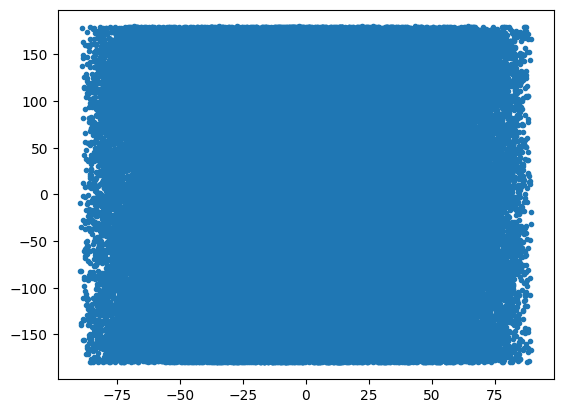

/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: overflow encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: invalid value encountered in matmul
  eci = ecef @ rot_mat.T


[-1.2450984e-12 -6.7780000e+03  0.0000000e+00] [ 7.66863568e+00 -1.40870552e-15  0.00000000e+00]
0 0
[[-7.34788079e-14 -4.00000000e+02  9.65685425e+02 -2.71120000e+06]
 [-9.65685425e+02 -4.00000000e+02  0.00000000e+00 -2.71120000e+06]
 [-1.83697020e-16 -1.00000000e+00  0.00000000e+00 -6.77800000e+03]]


/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: divide by zero encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: overflow encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: invalid value encountered in matmul
  points = (P @ points.T).T


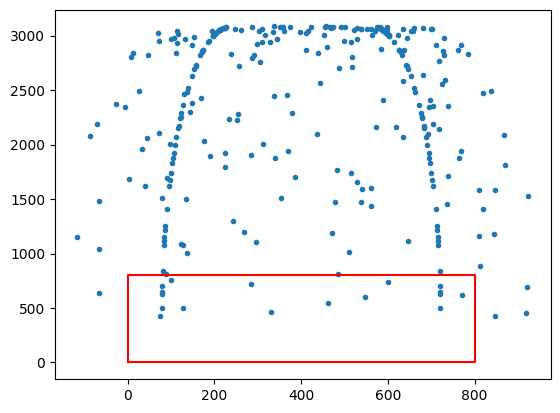

In [ ]:
t0 = datetime.datetime(2024, 1, 1)
t_end = datetime.datetime(2024, 1, 1, 0, 10, 0)

h = 400
field_of_regard = 45
crosstrack_discretization = 7.5 # deg
alongtrack_discretization = 10 # seconds
height = 800
width = 800
K = get_intrinsics_from_fov(45, width, height)
print(K)

t_s = 10
t_dotsq = 4
def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(np.abs(theta))

orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(0), Omega=np.pi, M=np.pi/2, t=t0)
requests = generate_requests(100000)

requests += [Request(r.id, -1.2, r.long, r.name) for r in requests[:1000]]
requests += [Request(r.id, 1.2, r.long, r.name) for r in requests[:1000]]

plt.plot([r.lat for r in requests], [r.long for r in requests], '.')
plt.show()

accesses = get_accesses(requests, orbit, 500, 45, t0, t_end)
schedule = milp_schedule(accesses, requests, agility_bangbang)

time = t0
orbit_new = propagate_orbit(orbit, time)
r , v = kepler2eci(orbit_new)
print(r, v)
pos_ecef = eci2ecef(r, time)

# Convert to ECEF points
accesses_converted = [(latlong2ecef([a.lat, a.long]), a.angle, a.time, a, i) for i, a in enumerate(accesses)]
accesses_filtered = filter_accesses_horizon(orbit_new, time, accesses_converted, pos_ecef)
points = np.array([r for r, _, _, _, _ in accesses_filtered])

# Get pitch and roll from action
pitch_deg = (np.rad2deg(horizon_angle(orbit_new))) - 22.5
# roll_deg = np.arcsin(action[2])
# For now roll_deg = 0
roll_deg = 0
print(pitch_deg, roll_deg)

# Now project them into the camera frame
projected_accesses, in_box, projected_points = project_in_box(pitch_deg, roll_deg, orbit_new, time, accesses_filtered, points, width, height, K)

plt.figure()
plt.plot(projected_points[:, 0], projected_points[:, 1], '.')
box = create_box(width, height, 2)
plt.plot(box[:, 0], box[:, 1], '-', color='red')
plt.show()
